In [1]:
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
import sys
import tqdm
import glob
import itertools

from os.path import expanduser
home = expanduser("~")

# Point to the recording folders, load the png files

In [2]:
# load the geometry
top_folder_0 = '/media/chrelli/Data0/recording_20190905-115115'
top_folder_1 = '/media/chrelli/Data1/recording_20190905-115115'

top_folder_0 = '/media/chrelli/Data0/recording_20200806-171004'
top_folder_1 = '/media/chrelli/Data1/recording_20200806-171004'

scene_folders = [top_folder_0,top_folder_0,top_folder_1,top_folder_1]
import pickle
geometry = pickle.load( open( scene_folders[0]+'/geometry.pkl', "rb" ) ) 
timing = pickle.load( open( scene_folders[0]+'/timing.pkl', "rb" ) )
print(geometry.keys())
print(timing.keys())


dict_keys(['start_frame', 'end_frame', 'd_cam_params', 'c_cam_params', 'R_extrinsics', 't_extrinsics', 'R_world', 't_world', 'M0', 'floor_point', 'floor_normal', 'c_cylinder', 'r_cylinder'])
dict_keys(['master_frame_table', 'reference_time_cam', 'reference_stamps', 'time_stamps', 'shifted_stamps'])


In [3]:
# use glob to make a list of the png files from all cameras
png_files = [glob.glob(scene_folders[i] + '/npy_raw/dev' +str(i) +'_cad_*.png') for i in range(4)]
png_files = [sorted(f) for f in png_files]


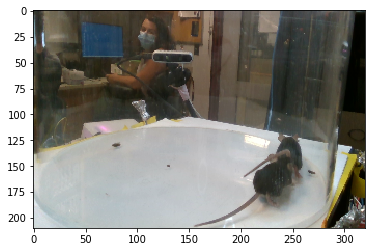

In [4]:
# Look at an example image
cam = 3
pic = cv2.imread(png_files[cam][230])
plt.imshow(pic[:,:,[2,1,0]])

# Pick 400 random images

In [5]:
# make a training stack!
n_train = 400
frame_height,frame_width = 210,320
# n x w x h x cam
sampled_c_frames = np.empty((n_train,frame_height,frame_width,3,4)).astype('uint8')

for cam in range(4):
    for i,frame in enumerate( np.random.choice(len(png_files[cam]),n_train) ):
        c_image = cv2.imread(png_files[cam][frame])
        sampled_c_frames[i,:,:,:,cam] = c_image
        
# and stack the four camera views together
sampled_c_frames = np.concatenate( [sampled_c_frames[:,:,:,:,i] for i in range(4)] ,axis = 0)


In [6]:
sampled_c_frames.shape

(1600, 210, 320, 3)

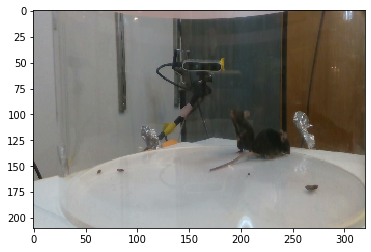

In [7]:
new_image = sampled_c_frames[500,...][:,:,[2,1,0]]
plt.imshow(new_image)

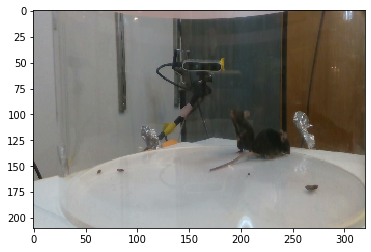

In [8]:

new_image = sampled_c_frames[500,...][:,:,[2,1,0]]
# * Enter the alpha value [1.0-3.0]: 2.2
alpha = 1#.5
# * Enter the beta value [0-100]: 50
beta = 0
pic = cv2.convertScaleAbs(new_image, -1, alpha, beta)
plt.imshow(pic)


(1600, 210, 320)

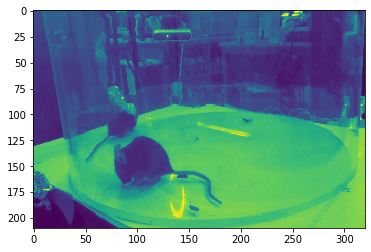

In [9]:
# make a greyscale version
sampled_g_frames = sampled_c_frames @ [0.2989, 0.5870, 0.1140]
sampled_g_frames = sampled_g_frames.astype('uint16')
plt.imshow(sampled_g_frames[0,:,:])
sampled_g_frames.shape

# k-means to group similar images in clusters

In [10]:
# do k-means on the greyscale images!
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils.validation import check_is_fitted

Machine = MiniBatchKMeans(n_clusters=12, init='k-means++', max_iter=1000,
                 batch_size=100, verbose=1, compute_labels=True,
                 random_state=None, tol=0.0, max_no_improvement=10,
                 init_size=None, n_init=10, reassignment_ratio=0.01)

# flatten everything, except the first dimension
g_frames_flat = np.reshape(sampled_g_frames,(sampled_g_frames.shape[0],-1))
# downsample here?
Machine.fit(g_frames_flat)
cluster_labels = Machine.predict(g_frames_flat)

# sampled_g_frames = sampled_g_frames.astype('uint8')
# plt.imshow(sampled_g_frames[0,:,:]

Init 1/10 with method: k-means++
Inertia for init 1/10: 7220651531.635397
Init 2/10 with method: k-means++
Inertia for init 2/10: 6930175400.743078
Init 3/10 with method: k-means++
Inertia for init 3/10: 7227462680.640038
Init 4/10 with method: k-means++
Inertia for init 4/10: 7151849952.495287
Init 5/10 with method: k-means++
Inertia for init 5/10: 6908825476.399019
Init 6/10 with method: k-means++
Inertia for init 6/10: 7167472275.270378
Init 7/10 with method: k-means++
Inertia for init 7/10: 7306844981.985325
Init 8/10 with method: k-means++
Inertia for init 8/10: 7186180872.065651
Init 9/10 with method: k-means++
Inertia for init 9/10: 6921897324.179050
Init 10/10 with method: k-means++
Inertia for init 10/10: 7283868185.883961
Minibatch iteration 1/16000: mean batch inertia: 27210317.443866, ewa inertia: 27210317.443866 
Minibatch iteration 2/16000: mean batch inertia: 24208856.793192, ewa inertia: 26835369.205181 
Minibatch iteration 3/16000: mean batch inertia: 24631542.187405, 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

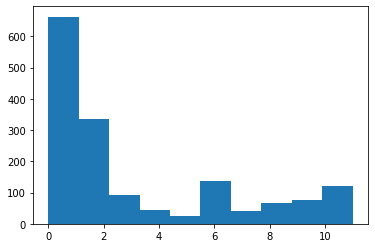

In [11]:
# show the images in the clusters
plt.hist(cluster_labels)
np.unique(cluster_labels)

# Sample from the clusters and save as hdf5 file

In [15]:
# save these random frames and cluster identity as a dataset
with h5py.File(top_folder_0 + '/mouse_training_set.h5', mode='w') as h5file:
    h5file.create_dataset('c_images', shape=sampled_c_frames.shape, dtype=np.uint8, data=sampled_c_frames[:,:,:,[2,1,0]])
    h5file.create_dataset('cluster_labels', shape=cluster_labels.shape, dtype=np.uint8, data=cluster_labels)


In [16]:
count,_ = np.histogram(cluster_labels,bins=np.arange(12+1))
count 
n_pr_cluster = np.min([ 60,  np.min(count) ])
print(n_pr_cluster)

reference_index = []

for i in range(12):
    in_cluster = cluster_labels == i
    reference_index.append(np.arange(sampled_c_frames.shape[0])[in_cluster][:n_pr_cluster])

reference_index = np.hstack([i for i in reference_index])
n_train = len(reference_index)
n_train

26


312

In [17]:
#save the training data!

n_train = len(reference_index)
with h5py.File(top_folder_0 + '/mouse_training_set.h5', mode='w') as h5file:
    c_dump = sampled_c_frames[reference_index,:,:,:]
    h5file.create_dataset('c_images', shape=c_dump.shape, dtype=np.uint8, data=c_dump[:,:,:,:])
    h5file.create_dataset('reference_index', shape=reference_index.shape, dtype=np.uint16, data=reference_index)


# Check the training set

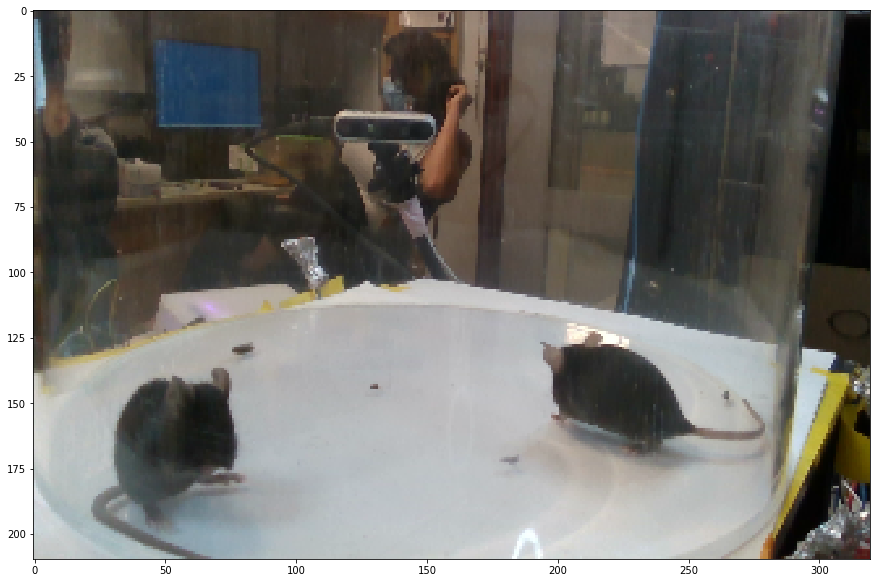

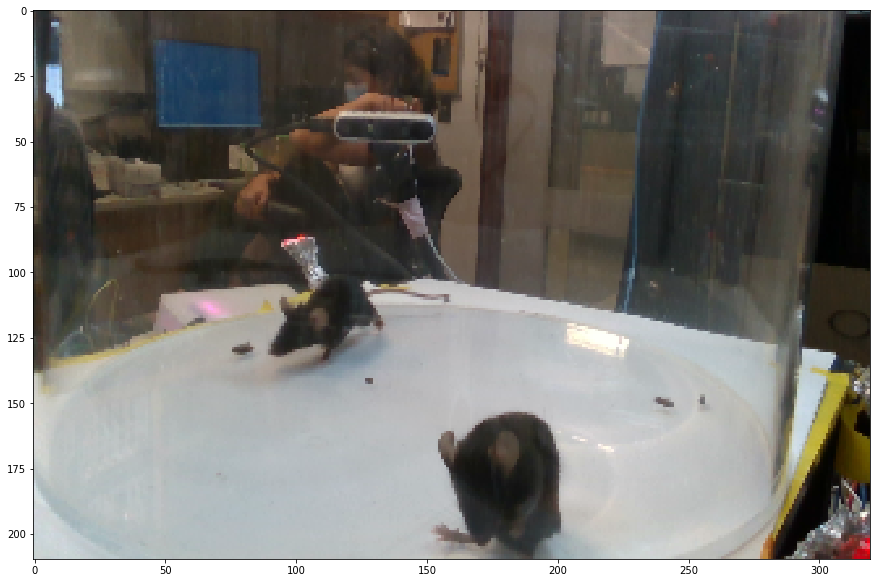

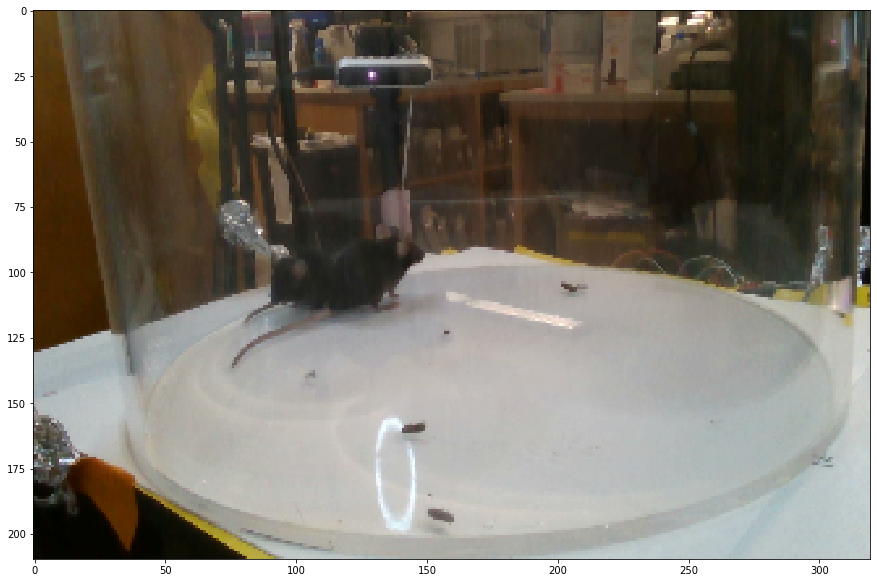

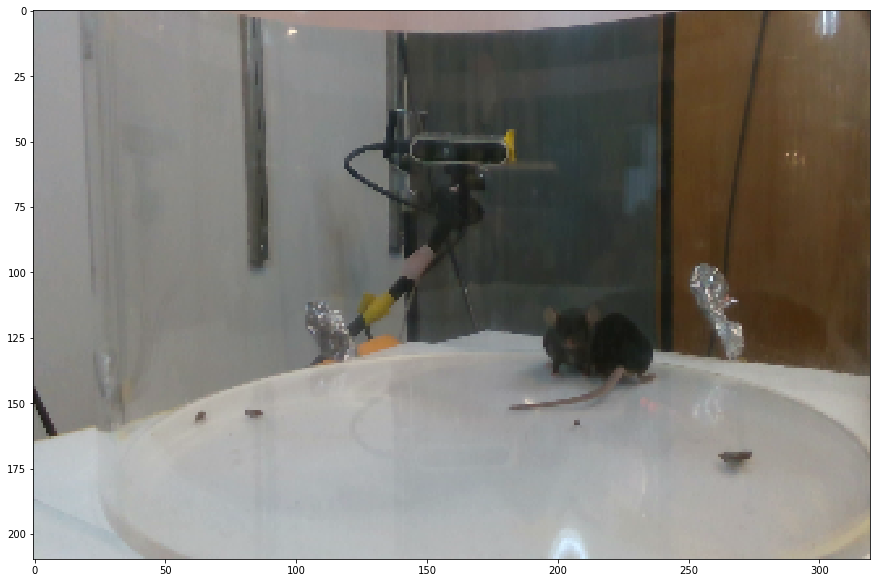

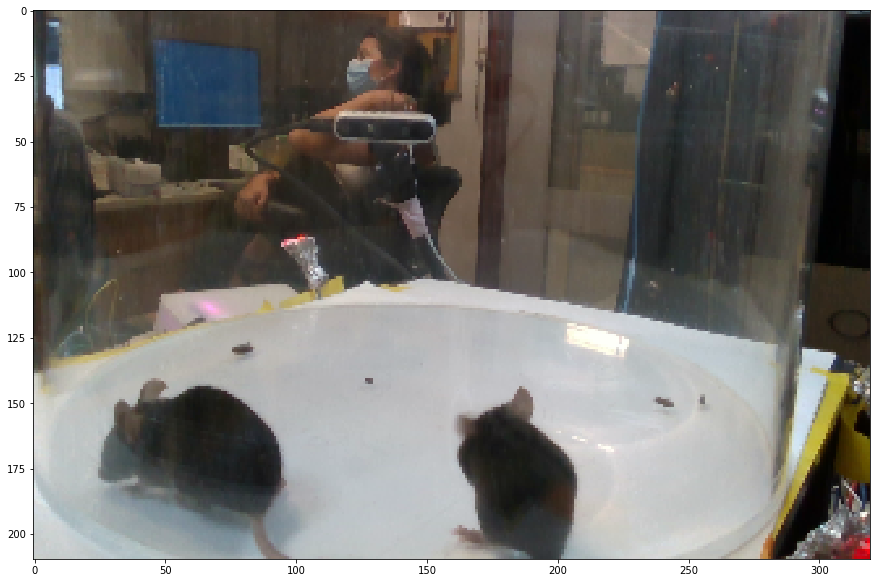

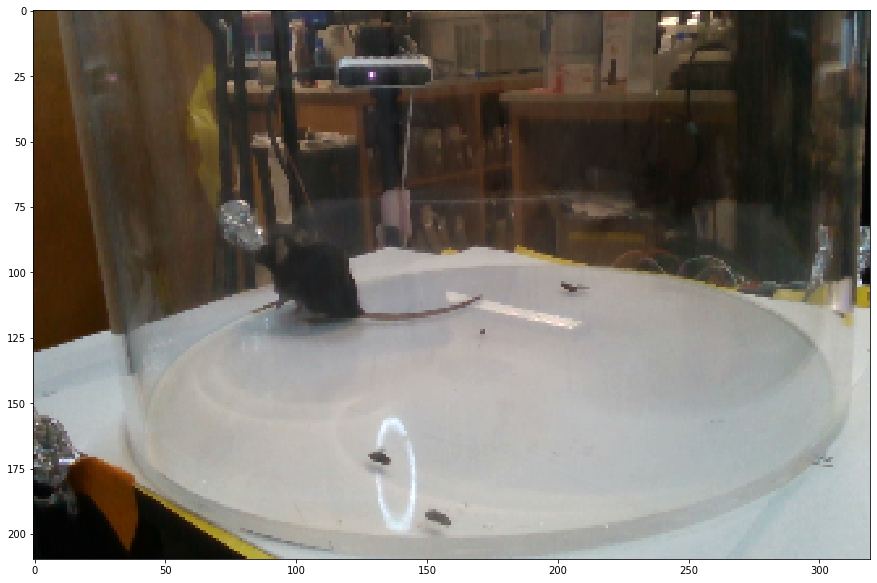

In [18]:
# Make sure the images are in the file
for _ in range(6):
    with h5py.File(top_folder_0 + '/mouse_training_set.h5', mode='r') as h5file:
        ji = np.random.choice(np.arange(n_train))
        h5_c_image = h5file['c_images'][ji]

    plt.figure(figsize=(15,15))
    plt.imshow(h5_c_image[:,:,[2,1,0]])
    plt.show()

    h5file.close()